In [1]:
!pip install openmeteo-requests
!pip install requests-cache retry-requests numpy pandas
!pip install --upgrade pandas


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


Enter your surface_area: 1000
Enter your postal code: N2T2K1
ac_monthly
[1804804.0977181, 2122547.078373405, 3522891.059704046, 3484297.610705242, 3863288.808973658, 4121919.185073823, 4298572.053870505, 3872879.590430121, 3293555.364435604, 2264440.703987484, 1644475.353061264, 1240874.531962636]
poa_monthly
[97.60248993984239, 118.2368343122822, 211.1929994263353, 210.0674855013018, 230.2677576739165, 251.3099971123299, 267.7896602878092, 239.5334055607219, 196.4932540927803, 130.3005812565761, 92.85398450823203, 68.63207040914911]
solrad_monthly
[3.14846741741427, 4.222744082581508, 6.812677400849527, 7.002249516710061, 7.427992183029565, 8.376999903744329, 8.638376138316426, 7.726884050345869, 6.54977513642601, 4.203244556663745, 3.095132816941068, 2.213937755133842]
dc_monthly
[1906290.994019177, 2292329.932959714, 3968671.746998232, 3797984.353847079, 4048996.762484135, 4315745.544707073, 4499327.483603458, 4051430.661526939, 3446678.910476061, 2375807.405276315, 1729438.43792180

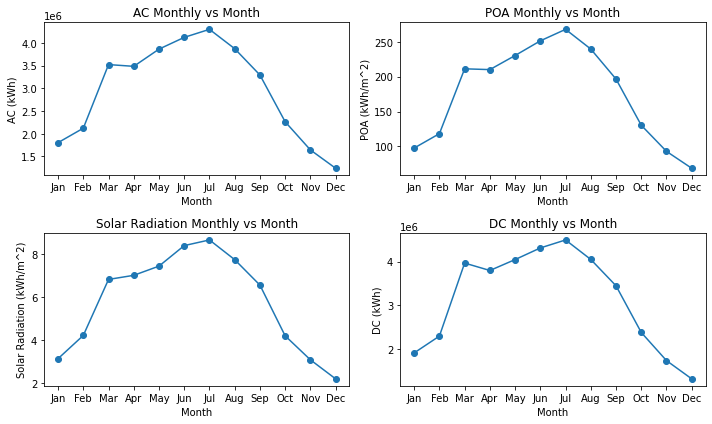

{'lat': 43.45000076293945, 'lon': -80.58000183105469, 'elev': 370.1199951171875, 'tz': -5.0, 'location': '1051271', 'city': '', 'state': 'Ontario', 'country': 'Canada', 'solar_resource_file': '1051271.csv', 'distance': 1200, 'weather_data_source': 'NSRDB PSM V3 GOES tmy-2020 3.2.0'}


In [2]:
import requests
import matplotlib.pyplot as plt


# Get the inputs from the GUI
surface_area = float(input("Enter your surface_area: "))
#address = address_entry.get()
address = str(input("Enter your postal code: "))

array_type = 2
module_type = 1
system_loss = 14.3
tilt = 20

# Calculate system capacity
solar_cell_efficiency = 21.3  # [%]
conversion_factor = 1  # [KW / m^2]
system_capacity = surface_area * solar_cell_efficiency * conversion_factor

# Define the URL for the PVWatts V8 API
url = "https://developer.nrel.gov/api/pvwatts/v8.json"
api_key = "rS4jhBrbjOjG2Rs1d2PZD6HGaIvO1gjDofyabEOV"

# Specify the parameters for the API request
params = {
    "api_key": api_key,
    "azimuth": 180,
    "system_capacity": system_capacity,
    "losses": system_loss,
    "array_type": array_type,
    "module_type": module_type,  
    "gcr": 0.4,
    "dc_ac_ratio": 1.2,
    "inv_eff": 96.0,
    "radius": 0,
    "timeframe": 'hourly',
    "dataset": "nsrdb",
    "tilt": tilt,
    "address": address,
    "albedo": 0.3,
    "bifaciality": 0.7
}

# Make the GET request to the PVWatts API
response = requests.get(url, params=params)

# Check if the request was successful
if response.status_code == 200:
    # Parse the JSON response
    data = response.json()

    # Display outputs
    ac_monthly = data["outputs"]["ac_monthly"]
    poa_monthly = data["outputs"]["poa_monthly"]
    solrad_monthly = data["outputs"]["solrad_monthly"]
    dc_monthly = data["outputs"]["dc_monthly"]
    
    station_info = data['station_info']
    
    print('ac_monthly')
    print(ac_monthly)
    
    print('poa_monthly')
    print(poa_monthly)
    
    print('solrad_monthly')
    print(solrad_monthly)
    
    print('dc_monthly')
    print(dc_monthly)
    

    # Plotting graphs
    months = [
        'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
        'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'
    ]

    plt.close('all')
    plt.figure(figsize=(10, 6))

    plt.subplot(2, 2, 1)
    plt.plot(months, ac_monthly, marker='o')
    plt.title('AC Monthly vs Month')
    plt.xlabel('Month')
    plt.ylabel('AC (kWh)')

    plt.subplot(2, 2, 2)
    plt.plot(months, poa_monthly, marker='o')
    plt.title('POA Monthly vs Month')
    plt.xlabel('Month')
    plt.ylabel('POA (kWh/m^2)')

    plt.subplot(2, 2, 3)
    plt.plot(months, solrad_monthly, marker='o')
    plt.title('Solar Radiation Monthly vs Month')
    plt.xlabel('Month')
    plt.ylabel('Solar Radiation (kWh/m^2)')

    plt.subplot(2, 2, 4)
    plt.plot(months, dc_monthly, marker='o')
    plt.title('DC Monthly vs Month')
    plt.xlabel('Month')
    plt.ylabel('DC (kWh)')

    plt.tight_layout()
    plt.show()

else:
    print('err')



# get logatude and latitude from station
print(station_info)

latitude = station_info["lat"]
longitude = station_info["lon"]

In [3]:
import openmeteo_requests

import requests_cache
import pandas as pd
from retry_requests import retry

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": latitude,
	"longitude": longitude,
	"start_date": "2022-01-01",
	"end_date": "2022-12-31",
	"hourly": ["temperature_2m", "relative_humidity_2m", "surface_pressure", "wind_speed_10m", "wind_speed_100m", "wind_direction_10m", "wind_direction_100m"]
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
hourly_relative_humidity_2m = hourly.Variables(1).ValuesAsNumpy()
hourly_surface_pressure = hourly.Variables(2).ValuesAsNumpy()
hourly_wind_speed_10m = hourly.Variables(3).ValuesAsNumpy()
hourly_wind_speed_100m = hourly.Variables(4).ValuesAsNumpy()
hourly_wind_direction_10m = hourly.Variables(5).ValuesAsNumpy()
hourly_wind_direction_100m = hourly.Variables(6).ValuesAsNumpy()

'''hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}'''

hourly_data = {
    "date": pd.date_range(
        start=pd.to_datetime(hourly.Time(), unit="s", utc=True),
        end=pd.to_datetime(hourly.TimeEnd(), unit="s", utc=True) - pd.Timedelta(seconds=1),  # Adjust end time
        freq=pd.Timedelta(seconds=hourly.Interval())
    )
}


hourly_data["temperature_2m"] = hourly_temperature_2m
hourly_data["relative_humidity_2m"] = hourly_relative_humidity_2m
hourly_data["surface_pressure"] = hourly_surface_pressure
hourly_data["wind_speed_10m"] = hourly_wind_speed_10m
hourly_data["wind_speed_100m"] = hourly_wind_speed_100m
hourly_data["wind_direction_10m"] = hourly_wind_direction_10m
hourly_data["wind_direction_100m"] = hourly_wind_direction_100m

hourly_dataframe = pd.DataFrame(data = hourly_data)
print(hourly_dataframe)


/home/npacey/.local/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/npacey/.local/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


Coordinates 43.47978591918945°N -80.54055786132812°E
Elevation 375.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s
                          date  temperature_2m  relative_humidity_2m  \
0    2022-01-01 00:00:00+00:00           0.318             98.562653   
1    2022-01-01 01:00:00+00:00           0.768             97.858711   
2    2022-01-01 02:00:00+00:00           0.368             97.497696   
3    2022-01-01 03:00:00+00:00           1.568             95.785301   
4    2022-01-01 04:00:00+00:00           1.968             94.773216   
...                        ...             ...                   ...   
8755 2022-12-31 19:00:00+00:00           5.818             98.625076   
8756 2022-12-31 20:00:00+00:00           6.268             97.613411   
8757 2022-12-31 21:00:00+00:00           5.568             98.280540   
8758 2022-12-31 22:00:00+00:00           4.968             97.248360   
8759 2022-12-31 23:00:00+00:00           4.368             97.577042   

      su

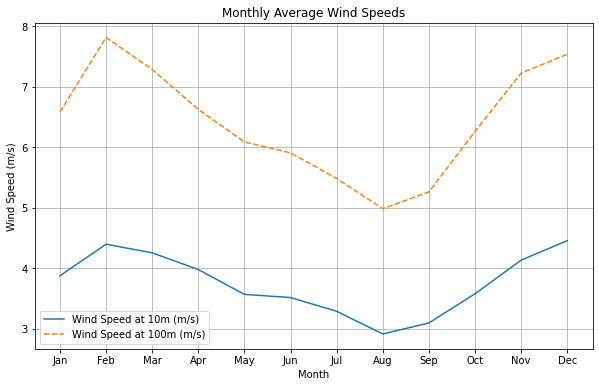

In [4]:
# Convert wind speeds from km/h to m/s
hourly_data["wind_speed_10m"] = hourly_data["wind_speed_10m"] / 3.6
hourly_data["wind_speed_100m"] = hourly_data["wind_speed_100m"] / 3.6

# Add the converted wind speeds to the DataFrame
hourly_dataframe = pd.DataFrame(data=hourly_data)

# Convert 'date' to a datetime index in the DataFrame
hourly_dataframe.set_index('date', inplace=True)

# Plotting wind speeds for each month
import matplotlib.pyplot as plt

# Extract month from the index (date)
hourly_dataframe['month'] = hourly_dataframe.index.month

# Group by month and calculate the mean wind speed for plotting
monthly_wind_speed_10m = hourly_dataframe.groupby('month')['wind_speed_10m'].mean()
monthly_wind_speed_100m = hourly_dataframe.groupby('month')['wind_speed_100m'].mean()

# Plotting
plt.figure(figsize=(10, 6))
monthly_wind_speed_10m.plot(label='Wind Speed at 10m (m/s)')
monthly_wind_speed_100m.plot(label='Wind Speed at 100m (m/s)', linestyle='--')
plt.title('Monthly Average Wind Speeds')
plt.xlabel('Month')
plt.ylabel('Wind Speed (m/s)')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend()
plt.grid(True)
plt.show()


/home/npacey/.local/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


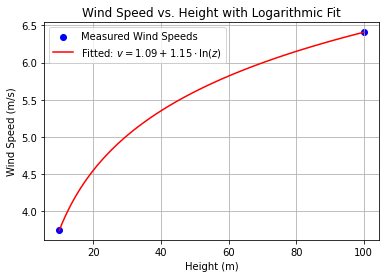

In [5]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Heights and average wind speeds
heights = np.array([10, 100])  # Heights in meters
average_wind_speeds = np.array([
    np.mean(hourly_data["wind_speed_10m"]),
    np.mean(hourly_data["wind_speed_100m"])
])

# Define the logarithmic wind profile function
def log_wind_profile(z, a, b):
    return a + b * np.log(z)

# Attempt to fit the curve
# Note: With only two data points, this is more of a demonstration than a robust fit.
try:
    popt, pcov = curve_fit(log_wind_profile, heights, average_wind_speeds)
    
    # Generate heights for the fitted curve visualization
    fitted_heights = np.linspace(10, 100, 100)  # From 10m to 100m
    fitted_speeds = log_wind_profile(fitted_heights, *popt)
    
    # Plotting the original data and the fitted curve
    plt.scatter(heights, average_wind_speeds, color='blue', label='Measured Wind Speeds')
    plt.plot(fitted_heights, fitted_speeds, 'r-', label=f'Fitted: $v = {popt[0]:.2f} + {popt[1]:.2f} \cdot \ln(z)$')
    plt.title('Wind Speed vs. Height with Logarithmic Fit')
    plt.xlabel('Height (m)')
    plt.ylabel('Wind Speed (m/s)')
    plt.legend()
    plt.grid(True)
    plt.show()

except Exception as e:
    print("An error occurred during curve fitting:", e)

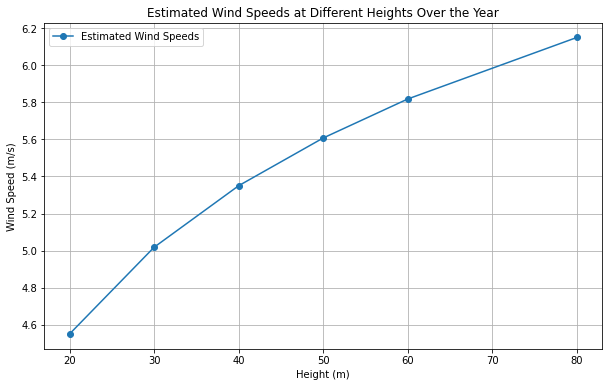

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming the curve fit parameters 'a' and 'b' were obtained as described previously
# Example parameters (replace with actual fitted values)
a, b = popt[0], popt[1]



# Heights for which we want to estimate wind speeds based on the fitted curve
estimated_heights = np.array([20, 30, 40, 50, 60, 80])

# Generate wind speeds for these heights using the fitted equation
estimated_wind_speeds = log_wind_profile(estimated_heights, a, b)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(estimated_heights, estimated_wind_speeds, 'o-', label='Estimated Wind Speeds')

plt.title('Estimated Wind Speeds at Different Heights Over the Year')
plt.xlabel('Height (m)')
plt.ylabel('Wind Speed (m/s)')
plt.legend()
plt.grid(True)
plt.show()


In [7]:
import numpy as np
from scipy.optimize import curve_fit

# Sample wind speeds at 10m and 100m for demonstration
# These should be replaced with your actual data arrays
wind_speed_10m = hourly_data["wind_speed_10m"]
wind_speed_100m = hourly_data["wind_speed_100m"]

# Define the heights for the wind speeds we have and the ones we want to interpolate
measured_heights = np.array([10, 100])
interpolate_heights = np.array([20, 30, 40, 50, 60, 80])

# Define the logarithmic wind profile function
def log_wind_profile(z, a, b):
    return a + b * np.log(z)

# Initialize a dictionary to store interpolated speeds
interpolated_speeds = {f'wind_speed_{h}m': [] for h in interpolate_heights}

# Iterate over each hour
for i in range(len(wind_speed_10m)):
    # Current wind speeds at 10m and 100m for the hour
    current_speeds = np.array([wind_speed_10m[i], wind_speed_100m[i]])
    
    # Fit the curve for this hour's data
    popt, _ = curve_fit(log_wind_profile, measured_heights, current_speeds)
    
    # Use the obtained fit to calculate speeds at desired heights
    for h in interpolate_heights:
        interpolated_speed = log_wind_profile(h, *popt)
        interpolated_speeds[f'wind_speed_{h}m'].append(interpolated_speed)

# After looping through all hours, interpolated_speeds will contain the estimated speeds for each height


/home/npacey/.local/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [8]:
for height, speeds in interpolated_speeds.items():
    hourly_data[height] = speeds

# Convert hourly_data to a DataFrame
hourly_dataframe = pd.DataFrame(data=hourly_data)
hourly_dataframe

date  temperature_2m  relative_humidity_2m  \
0    2022-01-01 00:00:00+00:00           0.318             98.562653   
1    2022-01-01 01:00:00+00:00           0.768             97.858711   
2    2022-01-01 02:00:00+00:00           0.368             97.497696   
3    2022-01-01 03:00:00+00:00           1.568             95.785301   
4    2022-01-01 04:00:00+00:00           1.968             94.773216   
...                        ...             ...                   ...   
8755 2022-12-31 19:00:00+00:00           5.818             98.625076   
8756 2022-12-31 20:00:00+00:00           6.268             97.613411   
8757 2022-12-31 21:00:00+00:00           5.568             98.280540   
8758 2022-12-31 22:00:00+00:00           4.968             97.248360   
8759 2022-12-31 23:00:00+00:00           4.368             97.577042   

      surface_pressure  wind_speed_10m  wind_speed_100m  wind_direction_10m  \
0           963.499207        1.649242         2.529822           75.963730   
1           963.095459        2.009975         4.080441           95.710503   
2           962.553040        2.195450         4.920366          120.068497   
3           962.175354        2.154066         4.609772          111.801476   
4           962.335510        1.562050         4.318565          129.805527   
...                ...             ...              ...                 ...   
8755        962.948792        1.303840         3.301515          265.601379   
8756        962.923889        1.802776         4.177320          273.179779   
8757        962.909546        2.912044         5.727128          285.945465   
8758        963.674561        3.498571         6.780118          300.963684   
8759        964.152405        3.361547         6.440496          300.379059   

      wind_direction_100m  wind_speed_20m  wind_speed_30m  wind_speed_40m  \
0              108.435043        1.914323        2.069386        2.179404   
1              126.027466        2.633248        2.997838        3.256520   
2              142.431335        3.015731        3.495565        3.836013   
3              139.398788        2.893307        3.325735        3.632548   
4              137.815628        2.391844        2.877242        3.221637   
...                   ...             ...             ...             ...   
8755           271.735657        1.905200        2.256973        2.506560   
8756           281.040894        2.517585        2.935721        3.232394   
8757           294.775116        3.759469        4.255180        4.606893   
8758           307.208008        4.486415        5.064267        5.474259   
8759           306.158264        4.288403        4.830579        5.215259   

      wind_speed_50m  wind_speed_60m  wind_speed_80m  
0           2.264741        2.334467        2.444485  
1           3.457169        3.621111        3.879792  
2           4.100084        4.315847        4.656294  
3           3.870531        4.064976        4.371789  
4           3.488771        3.707036        4.051431  
...              ...             ...             ...  
8755        2.700155        2.858333        3.107920  
8756        3.462511        3.650530        3.947202  
8757        4.879703        5.102605        5.454318  
8758        5.792274        6.052111        6.462103  
8759        5.513640        5.757435        6.142115  

[8760 rows x 14 columns]

In [9]:
# Check if 'date' is already the index or a column in the DataFrame
if 'date' in hourly_dataframe.columns:
    # Convert 'date' column to datetime if it exists as a column
    hourly_dataframe['date'] = pd.to_datetime(hourly_dataframe['date'])
    # Set 'date' as the DataFrame index
    hourly_dataframe.set_index('date', inplace=True)
elif not isinstance(hourly_dataframe.index, pd.DatetimeIndex):
    # If 'date' is not a column and the index is not already a DatetimeIndex, attempt conversion
    hourly_dataframe.index = pd.to_datetime(hourly_dataframe.index)

# Filter the DataFrame for January
january_data = hourly_dataframe[hourly_dataframe.index.month == 1]


<Figure size 1080x576 with 0 Axes>

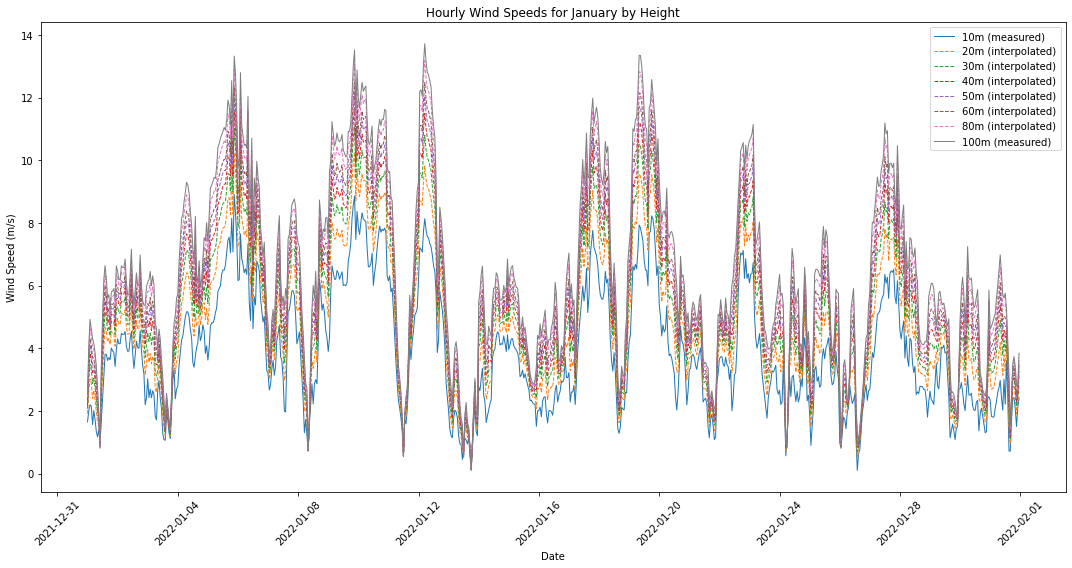

In [10]:
import matplotlib.pyplot as plt

# Plotting wind speeds for January
plt.figure(figsize=(15, 8))

# Ensure january_data's index and relevant columns are in a compatible format
dates = january_data.index.to_pydatetime()  # Convert index to pydatetime for compatibility
wind_speed_10m = january_data['wind_speed_10m'].to_numpy()  # Convert to numpy array
wind_speed_100m = january_data['wind_speed_100m'].to_numpy()  # Convert to numpy array

plt.figure(figsize=(15, 8))

# Plotting with explicit numpy arrays
plt.plot(dates, wind_speed_10m, label='10m (measured)', markersize=3, linestyle='-', linewidth=1)

# Interpolated wind speeds plotting
for height in ['20m', '30m', '40m', '50m', '60m', '80m']:
    speed_array = january_data[f'wind_speed_{height}'].to_numpy()  # Ensuring conversion to numpy array
    plt.plot(dates, speed_array, label=f'{height} (interpolated)', linestyle='--', linewidth=1)
    
plt.plot(dates, wind_speed_100m, label='100m (measured)', markersize=3, linestyle='-', linewidth=1)

plt.title('Hourly Wind Speeds for January by Height')
plt.xlabel('Date')
plt.ylabel('Wind Speed (m/s)')
plt.legend(loc='upper right')
plt.xticks(rotation=45)

# To improve the readability of the x-axis, consider setting a formatter or locator
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))  # Optional: Adjust the number of x-axis labels

plt.tight_layout()
plt.show()

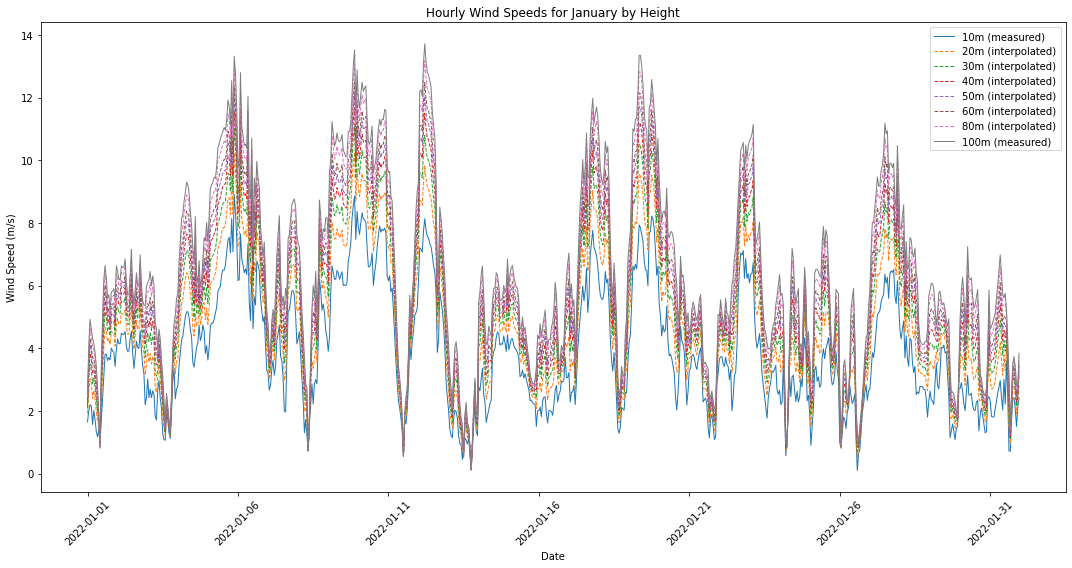

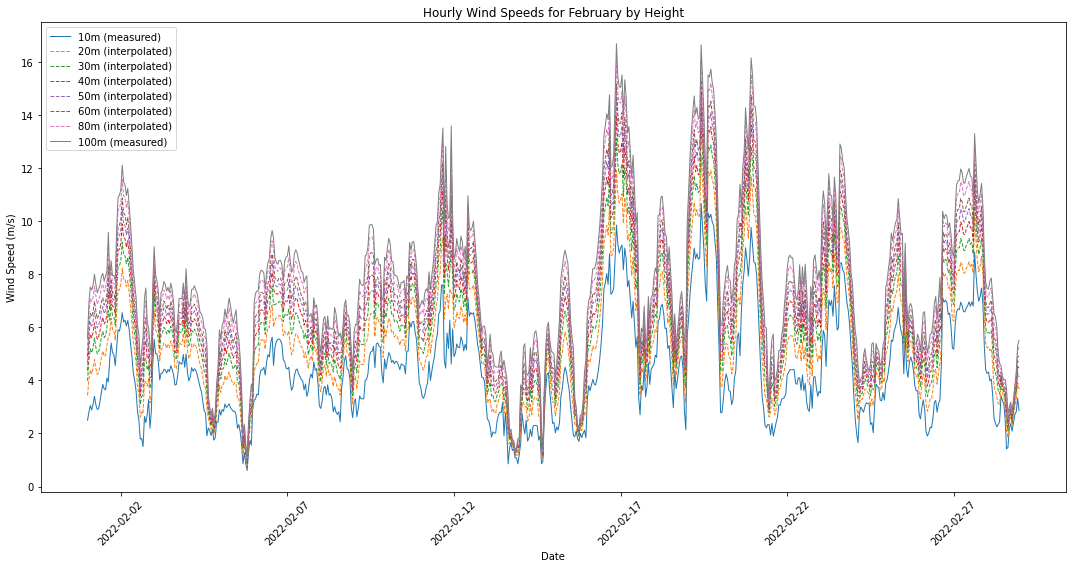

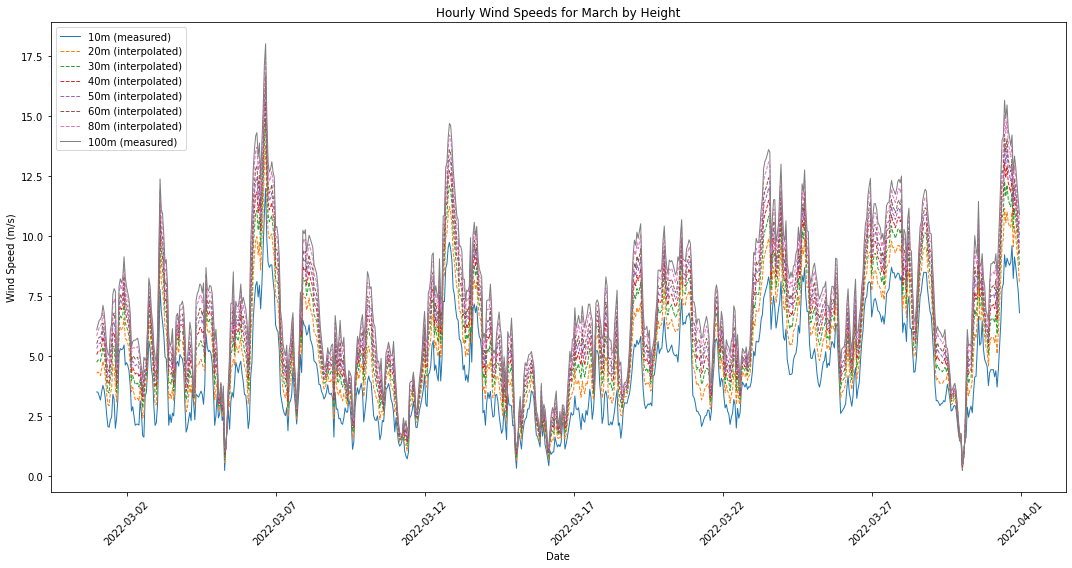

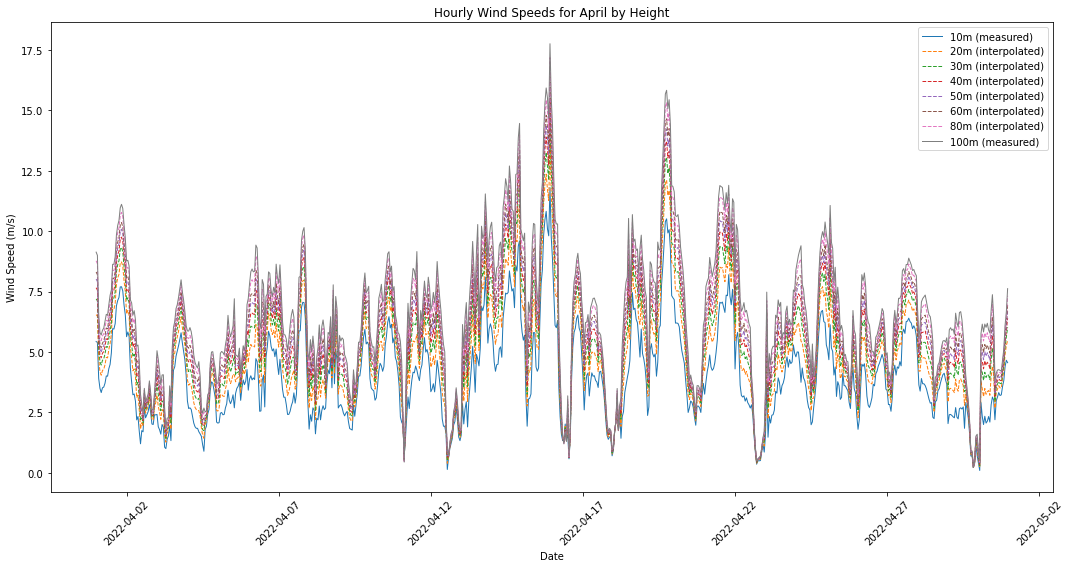

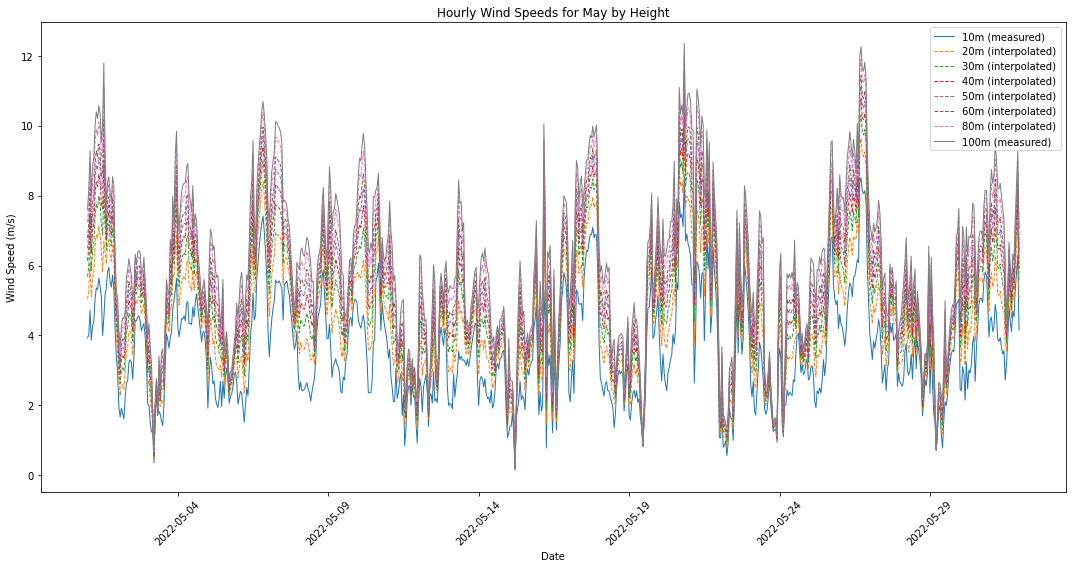

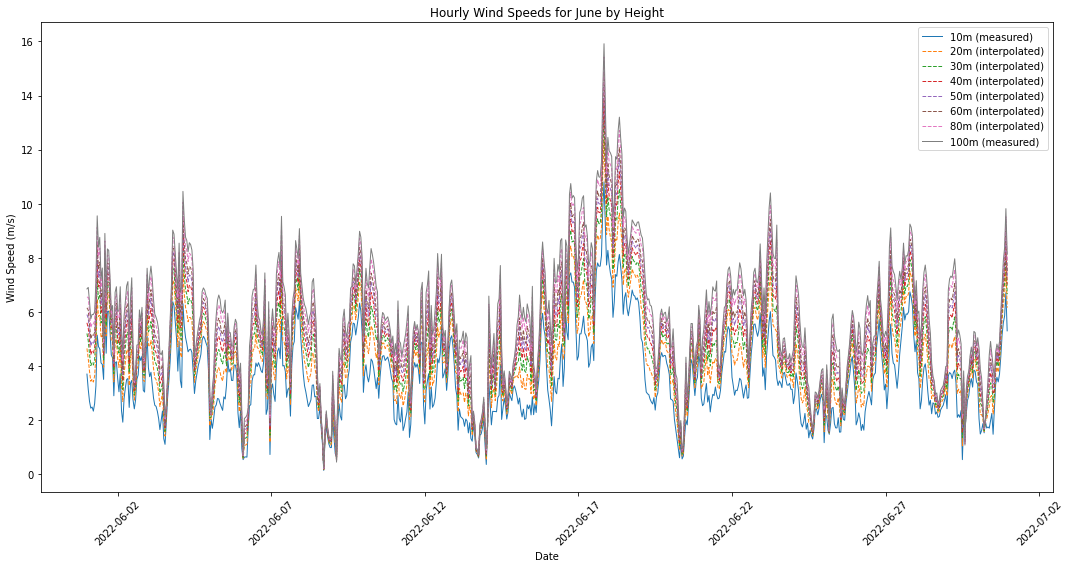

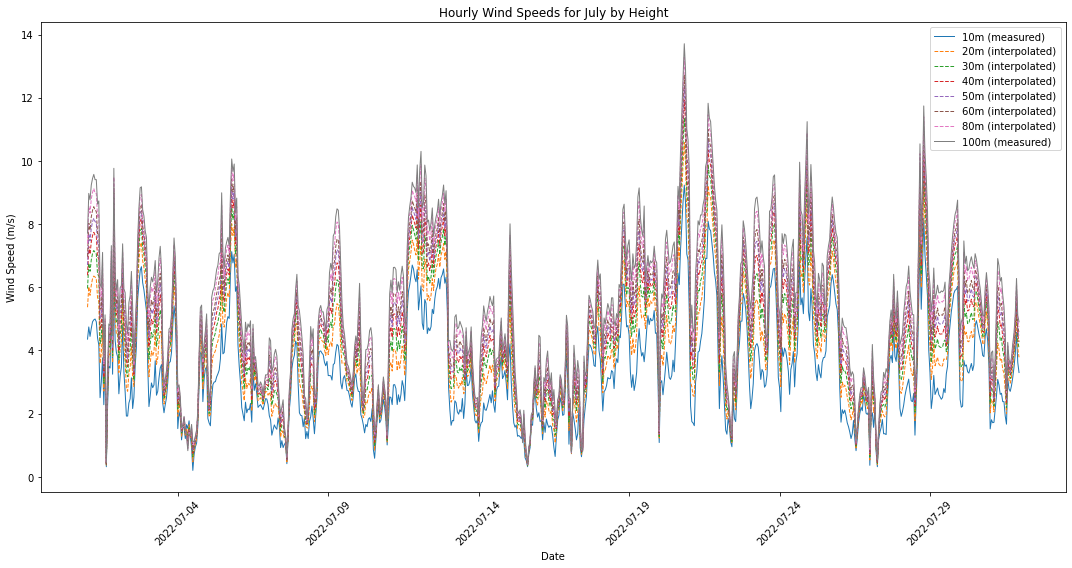

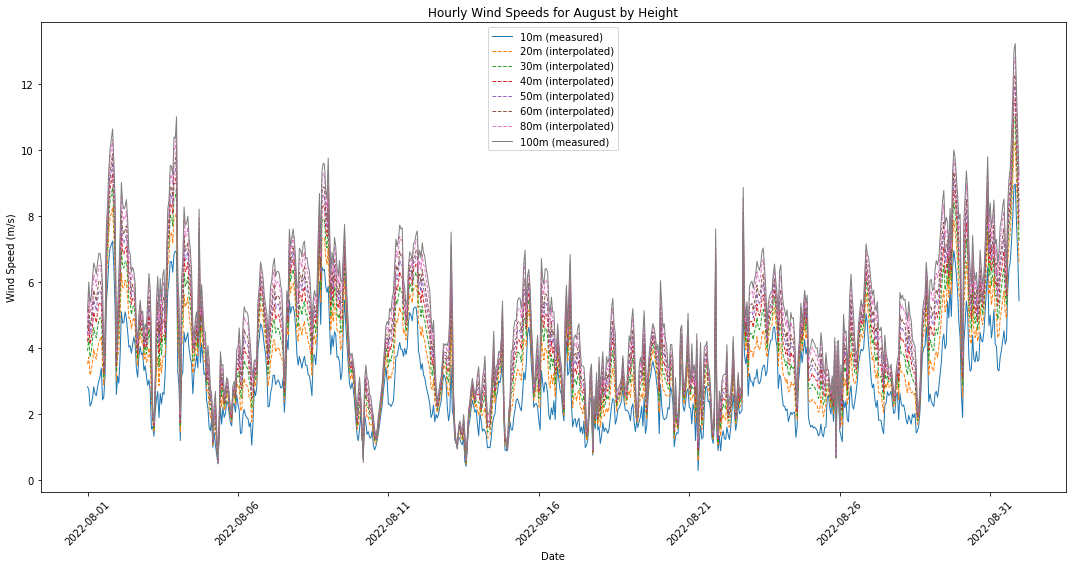

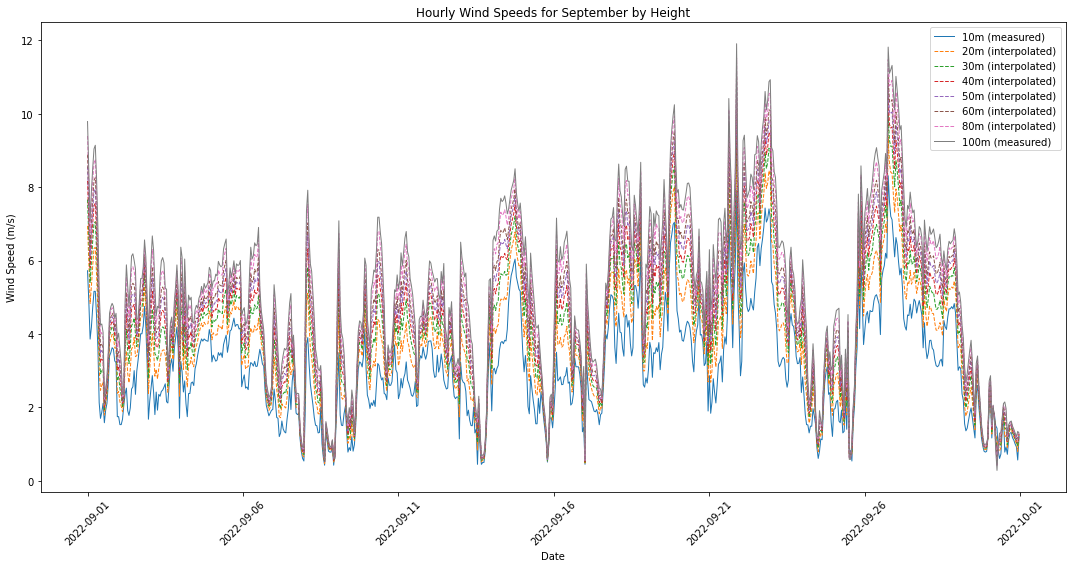

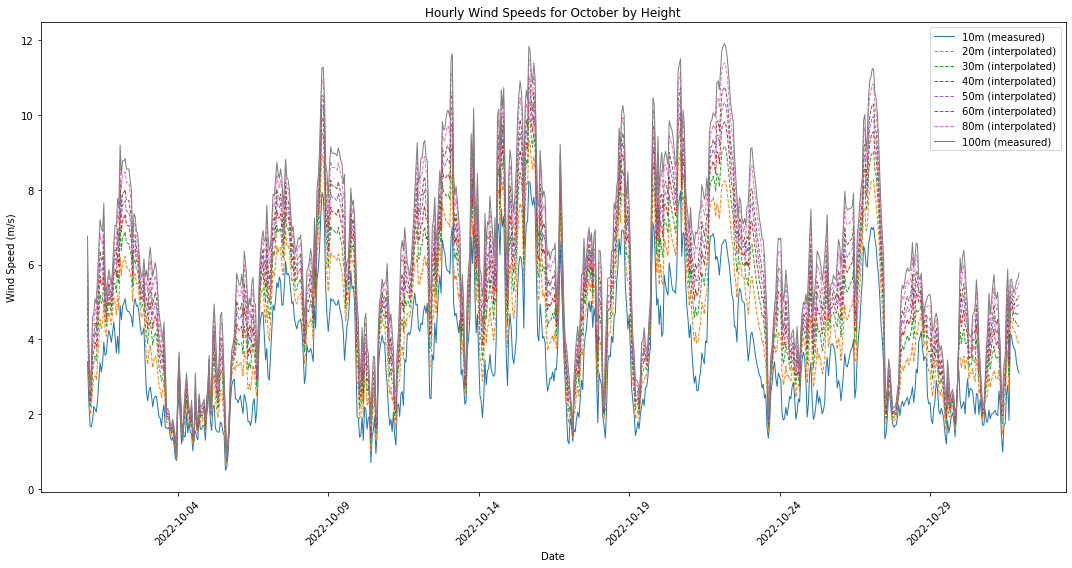

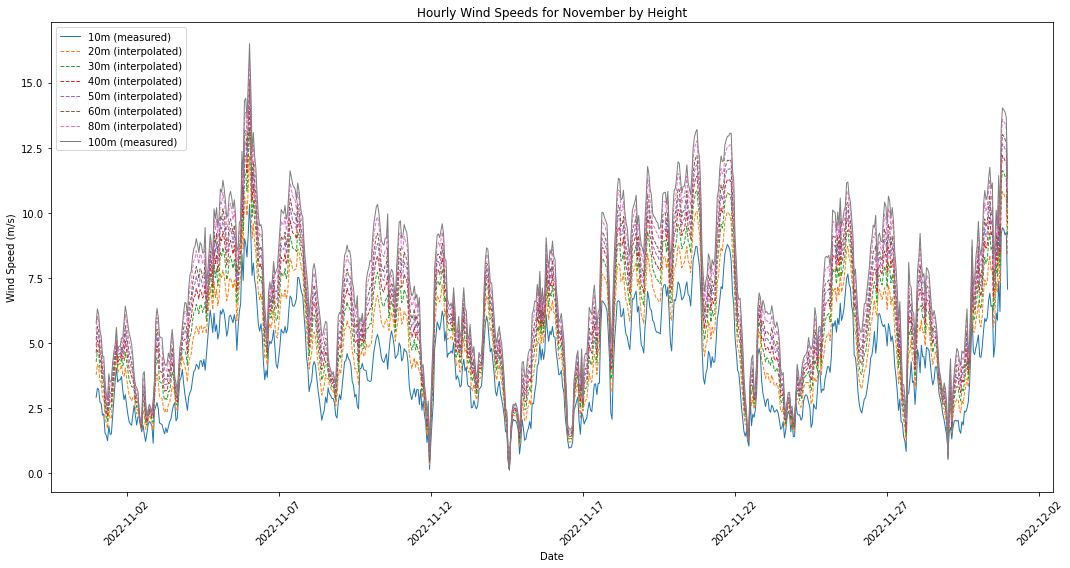

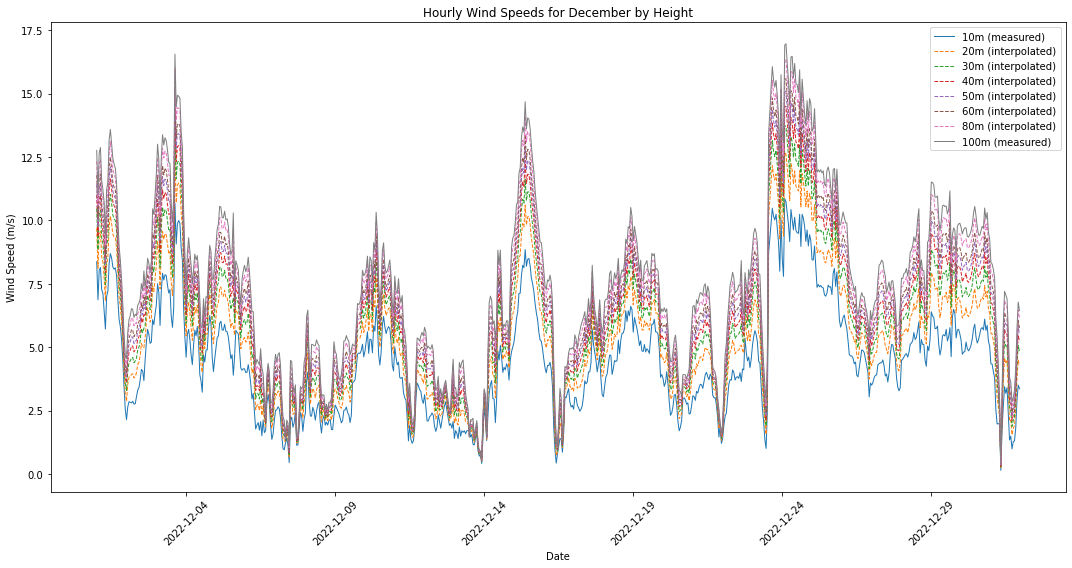

In [11]:
import matplotlib.dates as mdates
import calendar

for month in range(1, 13):  # Loop through each month
    # Filter data for the current month
    month_data = hourly_dataframe[hourly_dataframe.index.month == month]
    
    # Proceed only if there's data for this month
    if not month_data.empty:
        plt.figure(figsize=(15, 8))

        # Explicitly convert data to NumPy arrays for Matplotlib
        dates = month_data.index.to_pydatetime()  # Ensuring dates are in a compatible format
        wind_speed_10m = month_data['wind_speed_10m'].to_numpy()
        wind_speed_100m = month_data['wind_speed_100m'].to_numpy()

        # Plotting measured wind speeds
        plt.plot(dates, wind_speed_10m, label='10m (measured)', markersize=3, linestyle='-', linewidth=1)

        # Plotting interpolated wind speeds
        for height in ['20m', '30m', '40m', '50m', '60m', '80m']:
            interpolated_speed = month_data[f'wind_speed_{height}'].to_numpy()
            plt.plot(dates, interpolated_speed, label=f'{height} (interpolated)', linestyle='--', linewidth=1)

        plt.plot(dates, wind_speed_100m, label='100m (measured)', markersize=3, linestyle='-', linewidth=1)

        # Formatting the plot
        month_name = calendar.month_name[month]  # Get the name of the month
        plt.title(f'Hourly Wind Speeds for {month_name} by Height')
        plt.xlabel('Date')
        plt.ylabel('Wind Speed (m/s)')
        plt.legend(loc='best')
        plt.xticks(rotation=45)

        # Improve date formatting on x-axis
        plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))  # Show a date every 5 days
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        
        plt.tight_layout()
        plt.show()
    else:
        print(f"No data available for month {month}.")


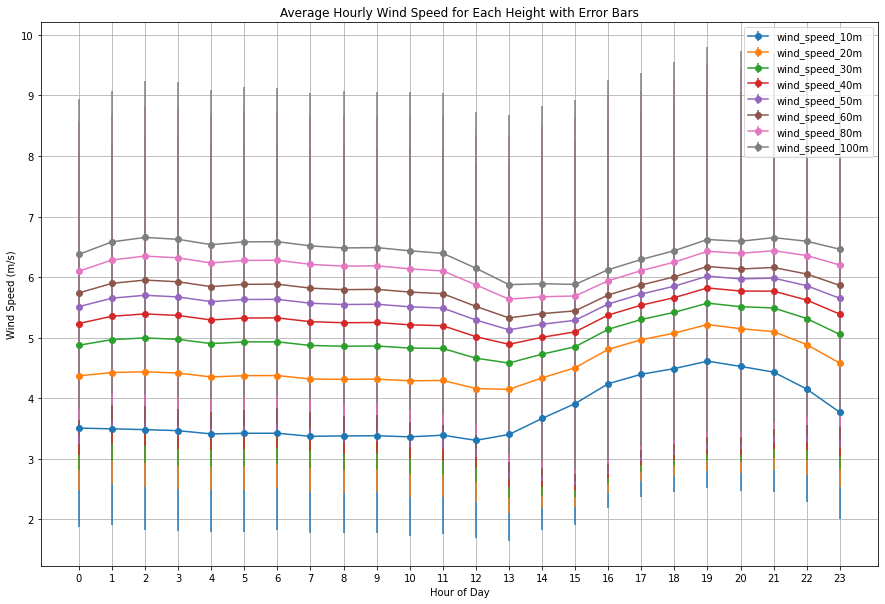

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Ensure 'hour' column is correct based on the 'date' index
hourly_dataframe['hour'] = hourly_dataframe.index.hour

# Specify the wind speed heights you have in your DataFrame
wind_speed_heights = ['wind_speed_10m', 'wind_speed_20m', 'wind_speed_30m', 
                      'wind_speed_40m', 'wind_speed_50m', 'wind_speed_60m', 
                      'wind_speed_80m', 'wind_speed_100m']

# Initialize a dictionary to hold our summary stats for each height
hourly_stats = {height: {'mean': [], 'std': []} for height in wind_speed_heights}

# Calculate mean and std for each height and hour
for height in wind_speed_heights:
    for hour in range(24):
        # Filter data for the current hour and height
        hourly_data = hourly_dataframe[hourly_dataframe['hour'] == hour][height]
        # Calculate mean and std, append to the respective lists
        hourly_stats[height]['mean'].append(hourly_data.mean())
        hourly_stats[height]['std'].append(hourly_data.std())

# Plotting
plt.figure(figsize=(15, 10))

# Plot mean wind speed with error bars for each height
for height in wind_speed_heights:
    plt.errorbar(range(24), hourly_stats[height]['mean'], yerr=hourly_stats[height]['std'], label=height, fmt='-o')

plt.title('Average Hourly Wind Speed for Each Height with Error Bars')
plt.xlabel('Hour of Day')
plt.ylabel('Wind Speed (m/s)')
plt.xticks(range(24))
plt.legend()
plt.grid(True)
plt.show()
